In [0]:
### Semantic Image Search

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir /content/models
!mkdir /content/output

In [26]:
!unzip "/content/drive/My Drive/Makeathon/MasterData.zip"
!7z x "Makeathon-master/level2_category1.7z" -o./Images
!7z x "Makeathon-master/level2_category2.7z" -o./Images
!7z x "Makeathon-master/level2_category3.7z" -o./Images
!7z x "Makeathon-master/level2_category4.7z" -o./Images
!7z x "Makeathon-master/level2_category5.7z" -o./Images
!7z x "Makeathon-master/level2_category6.7z" -o./Images 

Archive:  /content/drive/My Drive/Makeathon/MasterData.zip
451b646963b7ad6dfa39a4c64dadadc6c4dc4c3d
   creating: Makeathon-master/
 extracting: Makeathon-master/level2_category1.7z  
 extracting: Makeathon-master/level2_category2.7z  
 extracting: Makeathon-master/level2_category3.7z  
 extracting: Makeathon-master/level2_category4.7z  
 extracting: Makeathon-master/level2_category5.7z  
 extracting: Makeathon-master/level2_category6.7z  

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 11024359 bytes (11 MiB)

Extracting archive: Makeathon-master/level2_category1.7z
--
Path = Makeathon-master/level2_category1.7z
Type = 7z
Physical Size = 11024359
Headers Size = 60860
Method = LZMA:24
Solid = +
Blocks = 1

  0%     20% 498 - Taps/1392720.jpg

In [0]:
#!mv "/content/models/lsh.p" "/content/drive/My Drive/Makeathon/" 
#!mv "/content/models/stg2-rn34.pth" "/content/drive/My Drive/Makeathon/" 

In [0]:
!cp "/content/drive/My Drive/Makeathon/lsh.p" "/content/models/"
!cp "/content/drive/My Drive/Makeathon/lsh.p" "/content/"
!cp "/content/drive/My Drive/Makeathon/stg2-rn34.pth" "/content/models/"

In [24]:
!pip install lshash3

     |████████████████████████████████| 51kB 4.3MB/s 
  Created wheel for lshash3: filename=lshash3-0.0.8-py2.py3-none-any.whl size=10138 sha256=a0cb7339395e6f5fa5bc2824d9f3d4888f44c98b3032949e6b956d85f0ecb1aa
  Stored in directory: /root/.cache/pip/wheels/30/7f/09/f8d846b30660911ca453e60d71af991bd8a506e804a7df6100
  Created wheel for bitarray: filename=bitarray-1.2.1-cp36-cp36m-linux_x86_64.whl size=105055 sha256=1f97be139033e18cbc353cc1686c03ce508c1bb811e0b5d7f9d21f4eca3799c1
  Stored in directory: /root/.cache/pip/wheels/8e/4f/42/90d76aca9f4a7420c8c82fe15ed949777ab3fafe9fc1d705b3
Successfully built lshash3 bitarray


In [0]:
import click
import requests
from io import BytesIO
from pathlib import Path
import pickle
from PIL import Image as pil_img
import numpy as np
from fastai.vision.data import ImageDataBunch
from fastai.vision.transform import get_transforms
from fastai.vision.learner import create_cnn
from fastai.vision import models
from fastai.vision.image import pil2tensor, Image
import matplotlib
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from imutils import resize

In [0]:
def load_image_databunch(input_path, classes):
    """
    Code to define a databunch compatible with model
    """
    tfms = get_transforms(
        do_flip=False,
        flip_vert=False,
        max_rotate=0,
        max_lighting=0,
        max_zoom=1,
        max_warp=0,
    )

    data_bunch = ImageDataBunch.single_from_classes(Path(input_path), classes, ds_tfms=tfms, size=224)
    return data_bunch

In [0]:
def load_model(data_bunch, model_type, model_name):
    """
    Function to create and load pretrained weights of convolutional learner
    """
    learn = create_cnn(data_bunch, model_type, pretrained=False)
    learn.load(model_name)
    return learn

In [0]:
def download_img_from_url(url):
    '''
    Function to download image given a valid url
    '''
    try:
        response = requests.get(url)
        img = pil_img.open(BytesIO(response.content))
        resp = True
    except:
        resp = False
        img = np.nan
    return resp, img

In [0]:
class SaveFeatures:
    features = None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None

    def hook_fn(self, module, input, output):
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))

    def remove(self):
        self.hook.remove()

In [0]:
def image_to_vec(url_img, hook, learner):
    '''
    Function to convert image to vector
    '''
    print("Convert image to vec")
    _ = learner.predict(Image(pil2tensor(url_img, np.float32).div_(255)))
    vect = hook.features[-1]
    return vect

In [0]:
def get_similar_images(url_img, conv_learn, hook, lsh, show_image, output_path, n_items=5):
    
    ## Converting Image to vector
    vect = image_to_vec(url_img, hook, conv_learn)

    ## Finding approximate nearest neighbours using LSH
    response = lsh.query(vect, num_results=n_items + 1, distance_func="hamming")

    ## Dimension calculation for plotting
    columns = 3
    rows = int(np.ceil(n_items + 1 / columns)) + 1

    ## Plotting function
    fig = plt.figure(figsize=(2 * rows, 3 * rows))
    for i in range(1, columns * rows + 2):
        ## Plotting the url_img in center of first row
        if i == 1:
            fig.add_subplot(rows, columns, i + 1)
            plt.imshow(url_img)
            plt.axis("off")
            plt.title("Input Image")
        ## Plotting similar images row 2 onwards
        elif i < n_items + 2:
            ret_img = pil_img.open(response[i - 1][0][1])
            fig.add_subplot(rows, columns, i + 2)
            plt.imshow(ret_img)
            plt.axis("off")
            plt.title(str(i - 1))
    fig.tight_layout()
    fig.savefig(output_path, bbox_inches="tight", pad_inches=0)
    print("Image saved")

    ## Display if show_image is mentioned in argument
    if show_image:
        img = cv2.imread(output_path, 1)
        #print(img)
        #img = resize(img, width=300)
        #cv2.imshow("Similar images output", img)
        print("Similar images output")
        cv2_imshow(img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [0]:
classes = ['Abrasive Storage', 'Adhesives', 'Anchors', 'Annular Cutters', 'Application Equipment', 'Auto & Fleet Storage', 'Automotive Maintenance', 'Bandsaw Blades', 'Batteries', 'Body Hardware', 'Bodyshop', 'Bolts', 'Bonded Abrasives', 'Brake,Wheel', 'Brazing Alloys', 'Bristle Discs', 'Brooms, Brushes & Dust Pans', 'Cable Ties, Clamps & Accessories', 'Cable, Cord & Accessories', 'Carbide Burs', 'Casters and Wheels', 'Chain & Attachments', 'Chemical Storage', 'Cleaners', 'Clothing', 'Coated Abrasives', 'Coatings', 'Collars', 'Conduit & Accessories', 'Confined Space', 'Containers', 'Countersinks', 'Cutting Tool Storage', 'Deburring Tools', 'Dies', 'Dremel Product', 'Drill Bits', 'Drill Rod', 'Electrical Storage', 'Electrical Testing', 'Electrical Tools', 'Electrical Wire', 'End Mills', 'Ergonomics', 'Eye Protection', 'Eye Wash', 'Face Protection', 'Fall Protection', 'Fans', 'Files', 'Fire Protection', 'First Aid', 'Flame Resistant', 'Flammable Storage', 'Fleet & Automotive', 'Fleet,Truck', 'Floor Care', 'Fluid Handling Tools', 'Fluid Power Storage', 'Foot Protection', 'Fuses & Circuit Breakers,Testers', 'GHS', 'General Storage', 'Hand Protection', 'Hardfacing Alloys', 'Hardware', 'Head Protection', 'Hearing Protection', 'Hoists & Trolleys', 'Hole Saws', 'Identification', 'Identification Markers', 'Indexable Tooling', 'Instruments', 'Interior Vehicle Protection', 'Keys and Key Machines', 'LO,TO', 'Ladders, Platforms & Scaffolding', 'Lathe Tooling', 'Lighting', 'Literature', 'Lubricants', 'Lubrication Equipment', 'MBX', 'Matting', 'Miscellaneous Abrasives', 'Miscellaneous Fasteners', 'Non-Woven Products', 'Nuts', 'Odor Control', 'Other - Nonstock', 'Patching', 'Pest Control', 'Pins,Keystock', 'Protectors & Sleeves', 'Reamers', 'Repair Harness Assembly', 'Respiratory', 'Retaining Rings', 'Right To Know', 'Rivets', 'Rod,Studs', 'Roller Chain and Tools', 'Rope, Straps, & Tie Downs', 'Safety Storage', 'Saw Blades', 'Screws', 'Seasonal Maintenance', 'Seasonal Products', 'Security', 'Sewer and Drain', 'Shims,Shim Stock', 'Slings', 'Socket Screws', 'Sockets, Drive Tools & Accessories', 'Soldering', 'Specialty Maintenance', 'Spill Control', 'Springs', 'Steelmax® Tools', 'Storage', 'Support Materials', 'Tape', 'Taps', 'Temperature Instruments', 'Terminals & Wire Connectors', 'Thread Repair', 'Tool Sets', 'Tool Storage', 'Tool Storage & Equipment', 'Traffic Control', 'Universal Parts', 'Utility Carts', 'Waste Receptacles', 'Water Treatment', 'Wearplate', 'Welding', 'Welding Accessories', 'Welding Alloys', 'Welding Machines', 'Welding Process Products & Consumables', 'Welding Related Chemicals', 'Welding Storage', 'Welding Tools', 'Wheel Weights', 'Wiper Blades', 'Wipers,Rags,Towels', 'Wire', 'Wire Brushes', 'Wire Protection & Accessories', 'Wire Rope & Accessories', 'Wiring Devices', 'Wrenches & Accessories']

In [0]:
def find_similar_images(input_path, img_url, output_path, show_image, n_items):
    '''
    Function to run everything together
    '''
    resp, url_img = download_img_from_url(img_url)
    print("Image Download successful:{0}".format(resp))
    if resp:
        print("Load databunch")
        data_bunch = load_image_databunch(input_path, classes)

        print("Create a model")
        learner = load_model(data_bunch, models.resnet34, "stg2-rn34")

        print("Add a Hook")
        sf = SaveFeatures(learner.model[1][5])

        print("Load LSH table")
        lsh = pickle.load(open(Path(input_path) / "lsh.p", "rb"))

        print("Return similar items")
        get_similar_images(url_img, learner, sf, lsh, show_image, output_path, n_items=n_items)

    else:
        print("Image cannot be downloaded from URL please check the url link and try again.")

Image Download successful:True
Load databunch
Create a model


/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


Add a Hook
Load LSH table
Return similar items
Convert image to vec
Image saved


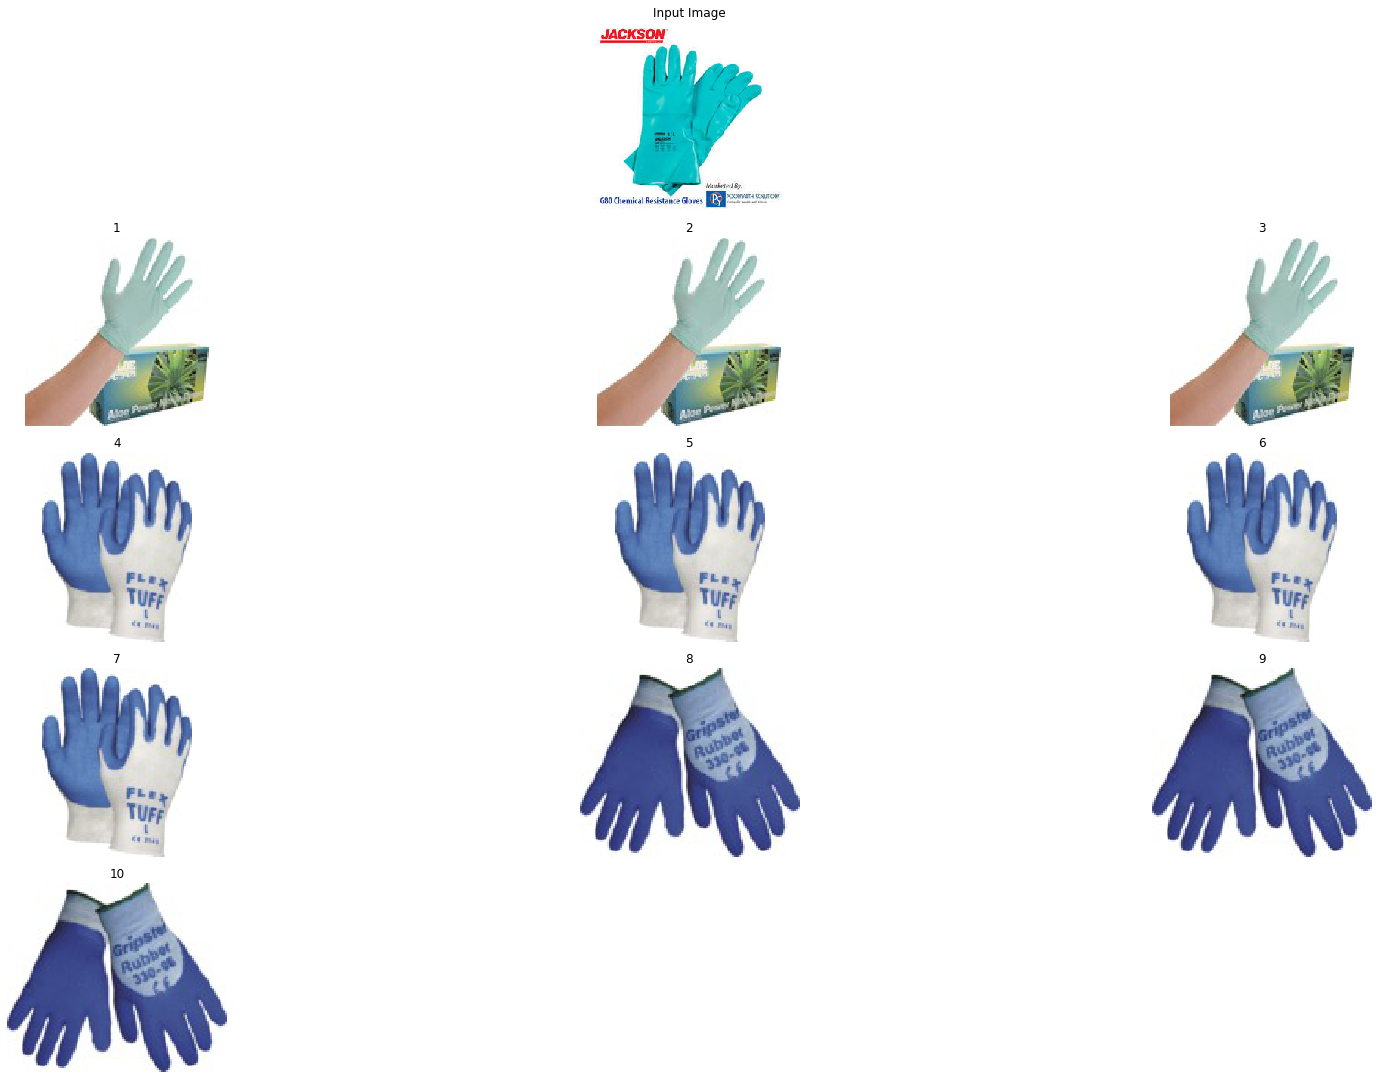

In [42]:
### Path for images, models and LSH table
input_path = "/content/"
### URL to get the image like https://cdn.mscdirect.com/global/images/ProductImages/0664260-21.jpg
img_url = "https://5.imimg.com/data5/AM/LS/MY-2548369/g80-250x250.jpg"       
output_path = "/content/output/"   ### Path to the output images
show_image = False   ### is_flag=True, To Display image in a openCV window
n_items = 10     ### Number of similar images b/w 1 to 20

find_similar_images(input_path, img_url, output_path, show_image, n_items)